In [1]:
import numpy as np
import os
import io
import matplotlib.pyplot as plt
%matplotlib notebook

## loading and saving data

In [18]:
images = []
labels = []

In [9]:
def load_images(directory, label):
    for filename in os.listdir(directory):
        file_path = directory + "/" + filename
        image = plt.imread(file_path)
        images.append(image)
        labels.append(label)

In [ ]:
load_images("./data/trash", 0)
load_images("./data/paper-recycling", 1)
load_images("./data/other-recycling", 2)

In [20]:
np.save("images.npy", np.array(images))
np.save("labels.npy", np.array(labels))

## Preprocessing and Memmap

In [3]:
images = np.load("./images.npy", mmap_mode="r")
labels = np.load("./labels.npy", mmap_mode="r")

In [8]:
images.shape

(2527, 384, 512, 3)

In [5]:
# compute mean
batch_size = int(len(labels) / 4)
sum_ = 0
for cnt in range(4):
    total = images[cnt * batch_size:(cnt + 1) * batch_size].sum(axis=0)
    sum_ += total
mean_images = sum_ / len(labels)

In [6]:
# compute standard deviation
total = 0
for cnt in range(4):
    total += np.sum((images[cnt * batch_size:(cnt + 1) * batch_size] - mean_images) ** 2, axis=0)
std_images = np.sqrt(total / len(labels))    

In [7]:
# save mean and std
np.save("./image_stats.npy", (np.array(mean_images), np.array(std_images)))

In [4]:
mean_images, std_images = np.load("./image_stats.npy")

In [6]:
# normalize all images
batch_size = int(len(labels) / 4)
normed_images = np.empty((2527, 3, 384, 512))
for cnt in range(4):
    normed_images[cnt * batch_size:(cnt + 1) * batch_size] = ((images[cnt * batch_size:(cnt + 1) * batch_size] - mean_images) / std_images).transpose(0,3,1,2)

In [13]:
# transpose to fix dimensions
normed_images = normed_images.transpose(0,3,1,2).copy()

memmap([[[[226, 198, 186],
          [226, 198, 186],
          [226, 198, 186],
          ...,
          [192, 172, 161],
          [192, 172, 161],
          [192, 172, 161]],

         [[226, 198, 186],
          [226, 198, 186],
          [226, 198, 186],
          ...,
          [193, 173, 162],
          [192, 172, 161],
          [192, 172, 161]],

         [[226, 198, 186],
          [226, 198, 186],
          [226, 198, 186],
          ...,
          [193, 173, 162],
          [193, 173, 162],
          [192, 172, 161]],

         ...,

         [[218, 191, 180],
          [218, 191, 180],
          [218, 191, 180],
          ...,
          [158, 139, 132],
          [157, 138, 131],
          [157, 138, 131]],

         [[218, 192, 179],
          [218, 192, 179],
          [218, 192, 179],
          ...,
          [158, 139, 132],
          [157, 138, 131],
          [157, 138, 131]],

         [[218, 192, 179],
          [218, 192, 179],
          [218, 192, 179],
         

In [7]:
# save normed images
np.save("./normed_images.npy", normed_images)

In [10]:
normed_images.shape

(2527, 384, 512, 3)

In [2]:
transposed_images = np.load("./transposed.npy", mmap_mode = "r")

In [26]:
transposed_images.dtype

dtype('float64')

In [3]:
labels = np.load("./labels.npy")

## Train and test data split (not finished)

In [4]:
idxs = np.arange(len(labels))
np.random.shuffle(idxs)
idxs = idxs
train_indices = idxs[0: int(0.75 * len(labels))]
test_indices = idxs[int(0.75 * len(labels)):]

## Model and training

In [2]:
import torch
from torch import tensor
import torch.nn as nn
relu = nn.functional.relu
cross_entropy = nn.CrossEntropyLoss()

In [4]:
class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 10, 11, 8)
        # self.pool1 = nn.MaxPool2d()
        self.conv2 = nn.Conv2d(10, 5, 5, 4)
        # self.pool2 = nn.MaxPool2d()
        self.dense1 = nn.Linear(30, 15)
        self.dense2 = nn.Linear(15, 3)
        self.norm1 = nn.BatchNorm2d(10)
        self.norm2 = nn.BatchNorm2d(5)
        self.dropout = nn.Dropout(p=0.2)
        
        # We have to separately overwrite the weights in the layers with
        # the initialization scheme that we desire. Here, we use the
        # "xavier-normal" initialization scheme for the weights, and 
        # initialize the biases to 0
        # Note that these functions update the weights in-place; this 
        # is denoted, in pytorch, by the trailing underscore in the
        # function name: `xavier_normal_`
        # This is merely a convention adopted by PyTorch
        for layer in (self.conv1, self.conv2, self.dense1, self.dense2):
            nn.init.xavier_normal_(layer.weight, np.sqrt(2))
            nn.init.constant_(layer.bias, 0)    
        
    def forward(self, x):
        ''' Forward data through the network.
        
        This allows us to conveniently initialize a model `m` and then send data through it
        to be classified by calling `m(x)`.
        
        Parameters
        ----------
        x : Union[numpy.ndarray, mygrad.Tensor], shape=(N, D)
            The data to forward through the network.
            
        Returns
        -------
        mygrad.Tensor, shape=(N, 1)
            The model outputs.
        '''
        # return self.dense3(relu(self.CNN(relu(self.dense1(x)))))
        x = relu(self.conv1(x))
        x = nn.functional.max_pool2d(x, 2)
        x = self.norm1(x)
        x = relu(self.conv2(x))
        x = nn.functional.max_pool2d(x, 2)
        x = self.norm2(x)
        x = relu(self.dense1(self.dropout(x.reshape(x.shape[0], -1))))
        return self.dense2(x)
    
    
def accuracy(predictions, truth):
    """
    Returns the mean classification accuracy for a batch of predictions.
    
    Parameters
    ----------
    predictions : Union[numpy.ndarray, mg.Tensor], shape=(M, D)
        The scores for D classes, for a batch of M data points
    truth : numpy.ndarray, shape=(M,)
        The true labels for each datum in the batch: each label is an
        integer in [0, D)
    
    Returns
    -------
    float
    """

    return np.mean((torch.argmax(predictions, dim=1) == truth).cpu().numpy())

In [25]:
# We will place these tensors in gpu memory, if a gpu is available, otherwise
# we will simply use the CPU. It is very unlikely that your laptop has a
# GPU for us to leverage.
device =  torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [19]:
device

device(type='cuda')

<IPython.core.display.Javascript object>


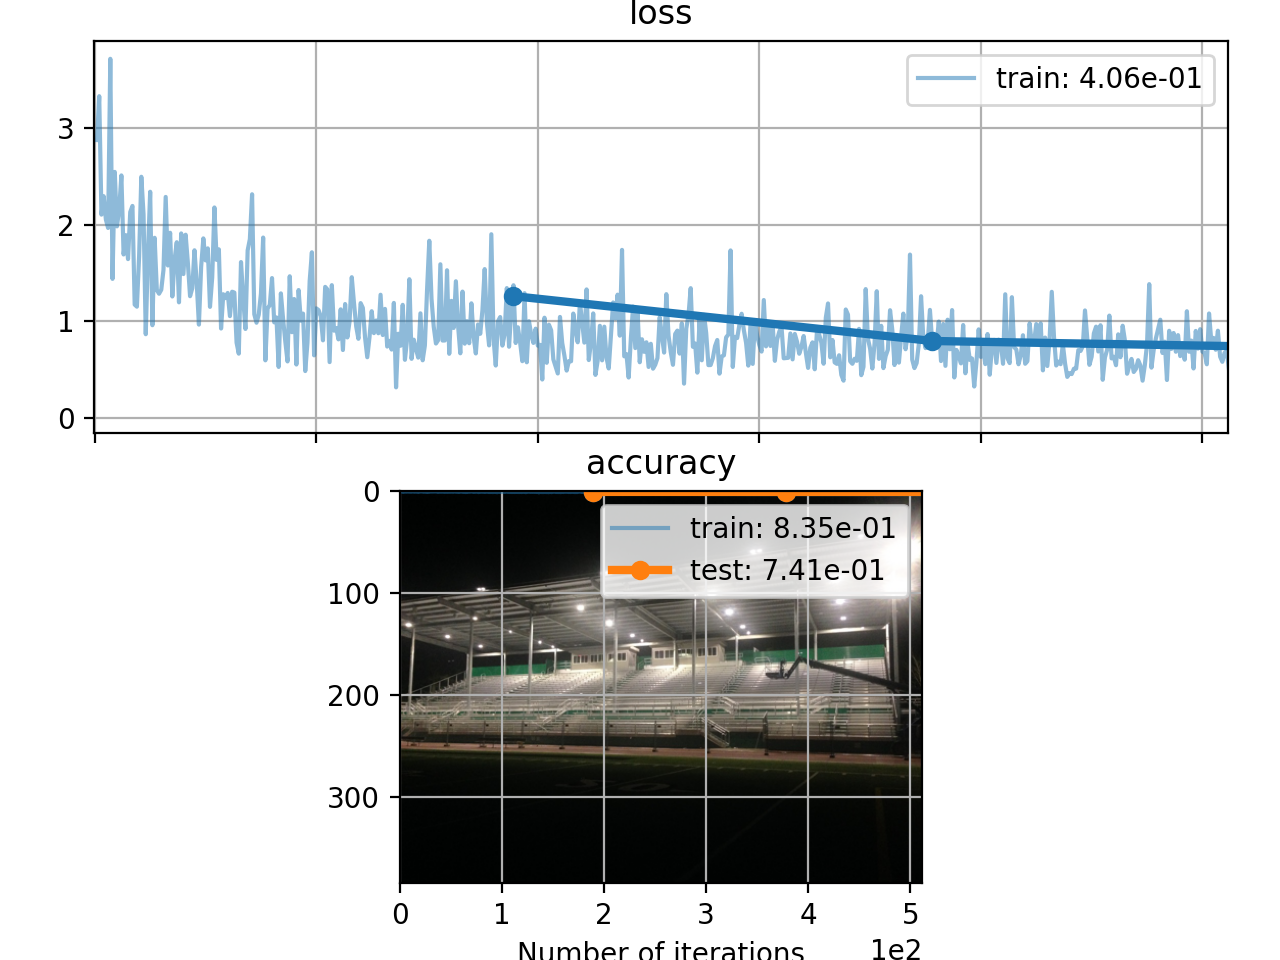

In [57]:
from noggin import create_plot
plotter, fig, ax = create_plot(metrics=["loss", "accuracy"])

In [58]:
# initialize our model and place its parameters on the GPU if it is available
model =  Model().to(device)

# initialize the optimizer
optim = torch.optim.Adam(model.parameters(), weight_decay=5E-3)

In [27]:
batch_x.dtype

dtype('float64')

In [67]:
num_epoch = 10
batch_size = 10

for epoch_cnt in range(num_epoch):
    for batch_cnt in range(len(train_indices) // batch_size):
        batch_x = transposed_images[train_indices[batch_cnt * batch_size : (batch_cnt + 1) * batch_size]]
        batch_y = labels[train_indices[batch_cnt * batch_size : (batch_cnt + 1) * batch_size]]
        
        x = torch.tensor(batch_x.copy(), dtype=torch.float32, device="cuda").to(device)
        y_true = torch.tensor(batch_y.copy(), dtype=torch.int64, device="cuda").to(device)
        y_pred = model(x)
        
        loss = cross_entropy(y_pred, y_true)
        loss.backward()
        optim.step()
        acc = accuracy(y_pred, y_true)
        
        optim.zero_grad()  # this is comparable to `null_gradients` in MyGrad
        plotter.set_train_batch({"loss" : loss.item(),
                                 "accuracy" : acc},
                                 batch_size=batch_size, plot=True)

    with torch.autograd.no_grad():
        for batch_cnt in range(0, len(test_indices)//batch_size):
            batch_x_t = transposed_images[test_indices[batch_cnt * batch_size : (batch_cnt + 1) * batch_size]]
            batch_y_t = labels[test_indices[batch_cnt * batch_size : (batch_cnt + 1) * batch_size]]
            
            x_t = torch.tensor(batch_x_t.copy(), dtype=torch.float32, device="cuda").to(device)
            y_true_t = torch.tensor(batch_y_t.copy(), dtype=torch.int64, device="cuda").to(device)
            y_pred_t = model(x_t)
            
            acc = accuracy(y_pred_t, y_true_t)
            plotter.set_test_batch({ "accuracy" : acc},
                                     batch_size=batch_size)
    plotter.set_train_epoch()
    plotter.set_test_epoch()

        # test_data = torch.tensor(y_train, dtype=torch.int64).to(device)

        # X = torch.tensor(x_test).to(device)
        # Y = torch.tensor(y_test, dtype=torch.int64).to(device)
plotter.plot()

KeyboardInterrupt: 

In [64]:
torch.save(model.state_dict(), "./model_weights.pth")

In [ ]:
model.load_state_dict(torch.load(PATH))

In [65]:
torch.save(model, "./model.pth")

In [5]:
model = torch.load("./model.pth")

In [41]:
from camera import take_picture
def identify_from_camera():
    # pic = resize(take_pic(), 384, 512)
    pic = Image.fromarray(take_picture())
    resized = np.asarray(expand(pic, (255, 255, 255)))
    reshaped = resized.reshape(1, *resized.shape)
    transposed = reshaped.transpose(0, 3, 1, 2)
    class_ = np.argmax(model(torch.tensor(transposed, dtype=torch.float32, device="cuda")).cpu().detach())  
    if class_ == 0:
        return pic, "trash"
    elif class_ == 1:
        return pic, "paper recycling"
    elif class_ == 2:
        return pic, "other recycling"

In [113]:
mean_images, std_images = np.load("./image_stats.npy")
mean_images.shape

(384, 512, 3)

In [130]:
def identify(file_path, bw=False):
    # pic = resize(take_pic(), 384, 512)
    mean_images, std_images = np.load("./image_stats.npy")
    pic = Image.open(file_path)
    resized = ((np.asarray(expand(pic, (255, 255, 255)))[:, :, :3] - mean_images) / std_images).transpose(2, 0, 1)
    print(resized.shape)
    # greyimg = np.einsum("chw, c", resized, [0.2989, 0.5870, 0.1140])
    # bw_img = np.stack([greyimg, greyimg, greyimg])
    reshaped = resized.reshape(1, *resized.shape)
    # transposed[np.where(transposed>=127)] = 255.0
    # transposed[np.where(transposed<127)] = 0.0
    
    class_ = np.argmax(model(torch.tensor(reshaped, dtype=torch.float32, device="cuda")).cpu().detach())  
    
    if class_ == 0:
        return pic, "trash"
    elif class_ == 1:
        return pic, "paper recycling"
    elif class_ == 2:
        return pic, "other recycling"

In [10]:
from PIL import Image

In [11]:
def expand(pil_img, background_color):
    width, height = pil_img.size
    if width / 4 == height / 3:
        return pil_img.resize((512, 384))
    elif width / 4 > height / 3:
        result = Image.new(pil_img.mode, (width, int(width * 3 / 4)), background_color)
        result.paste(pil_img)
        return result.resize((512, 384))
    else:
        result = Image.new(pil_img.mode, (int(height * 4 / 3), height), background_color)
        result.paste(pil_img)
        return result.resize((512, 384))

<IPython.core.display.Javascript object>


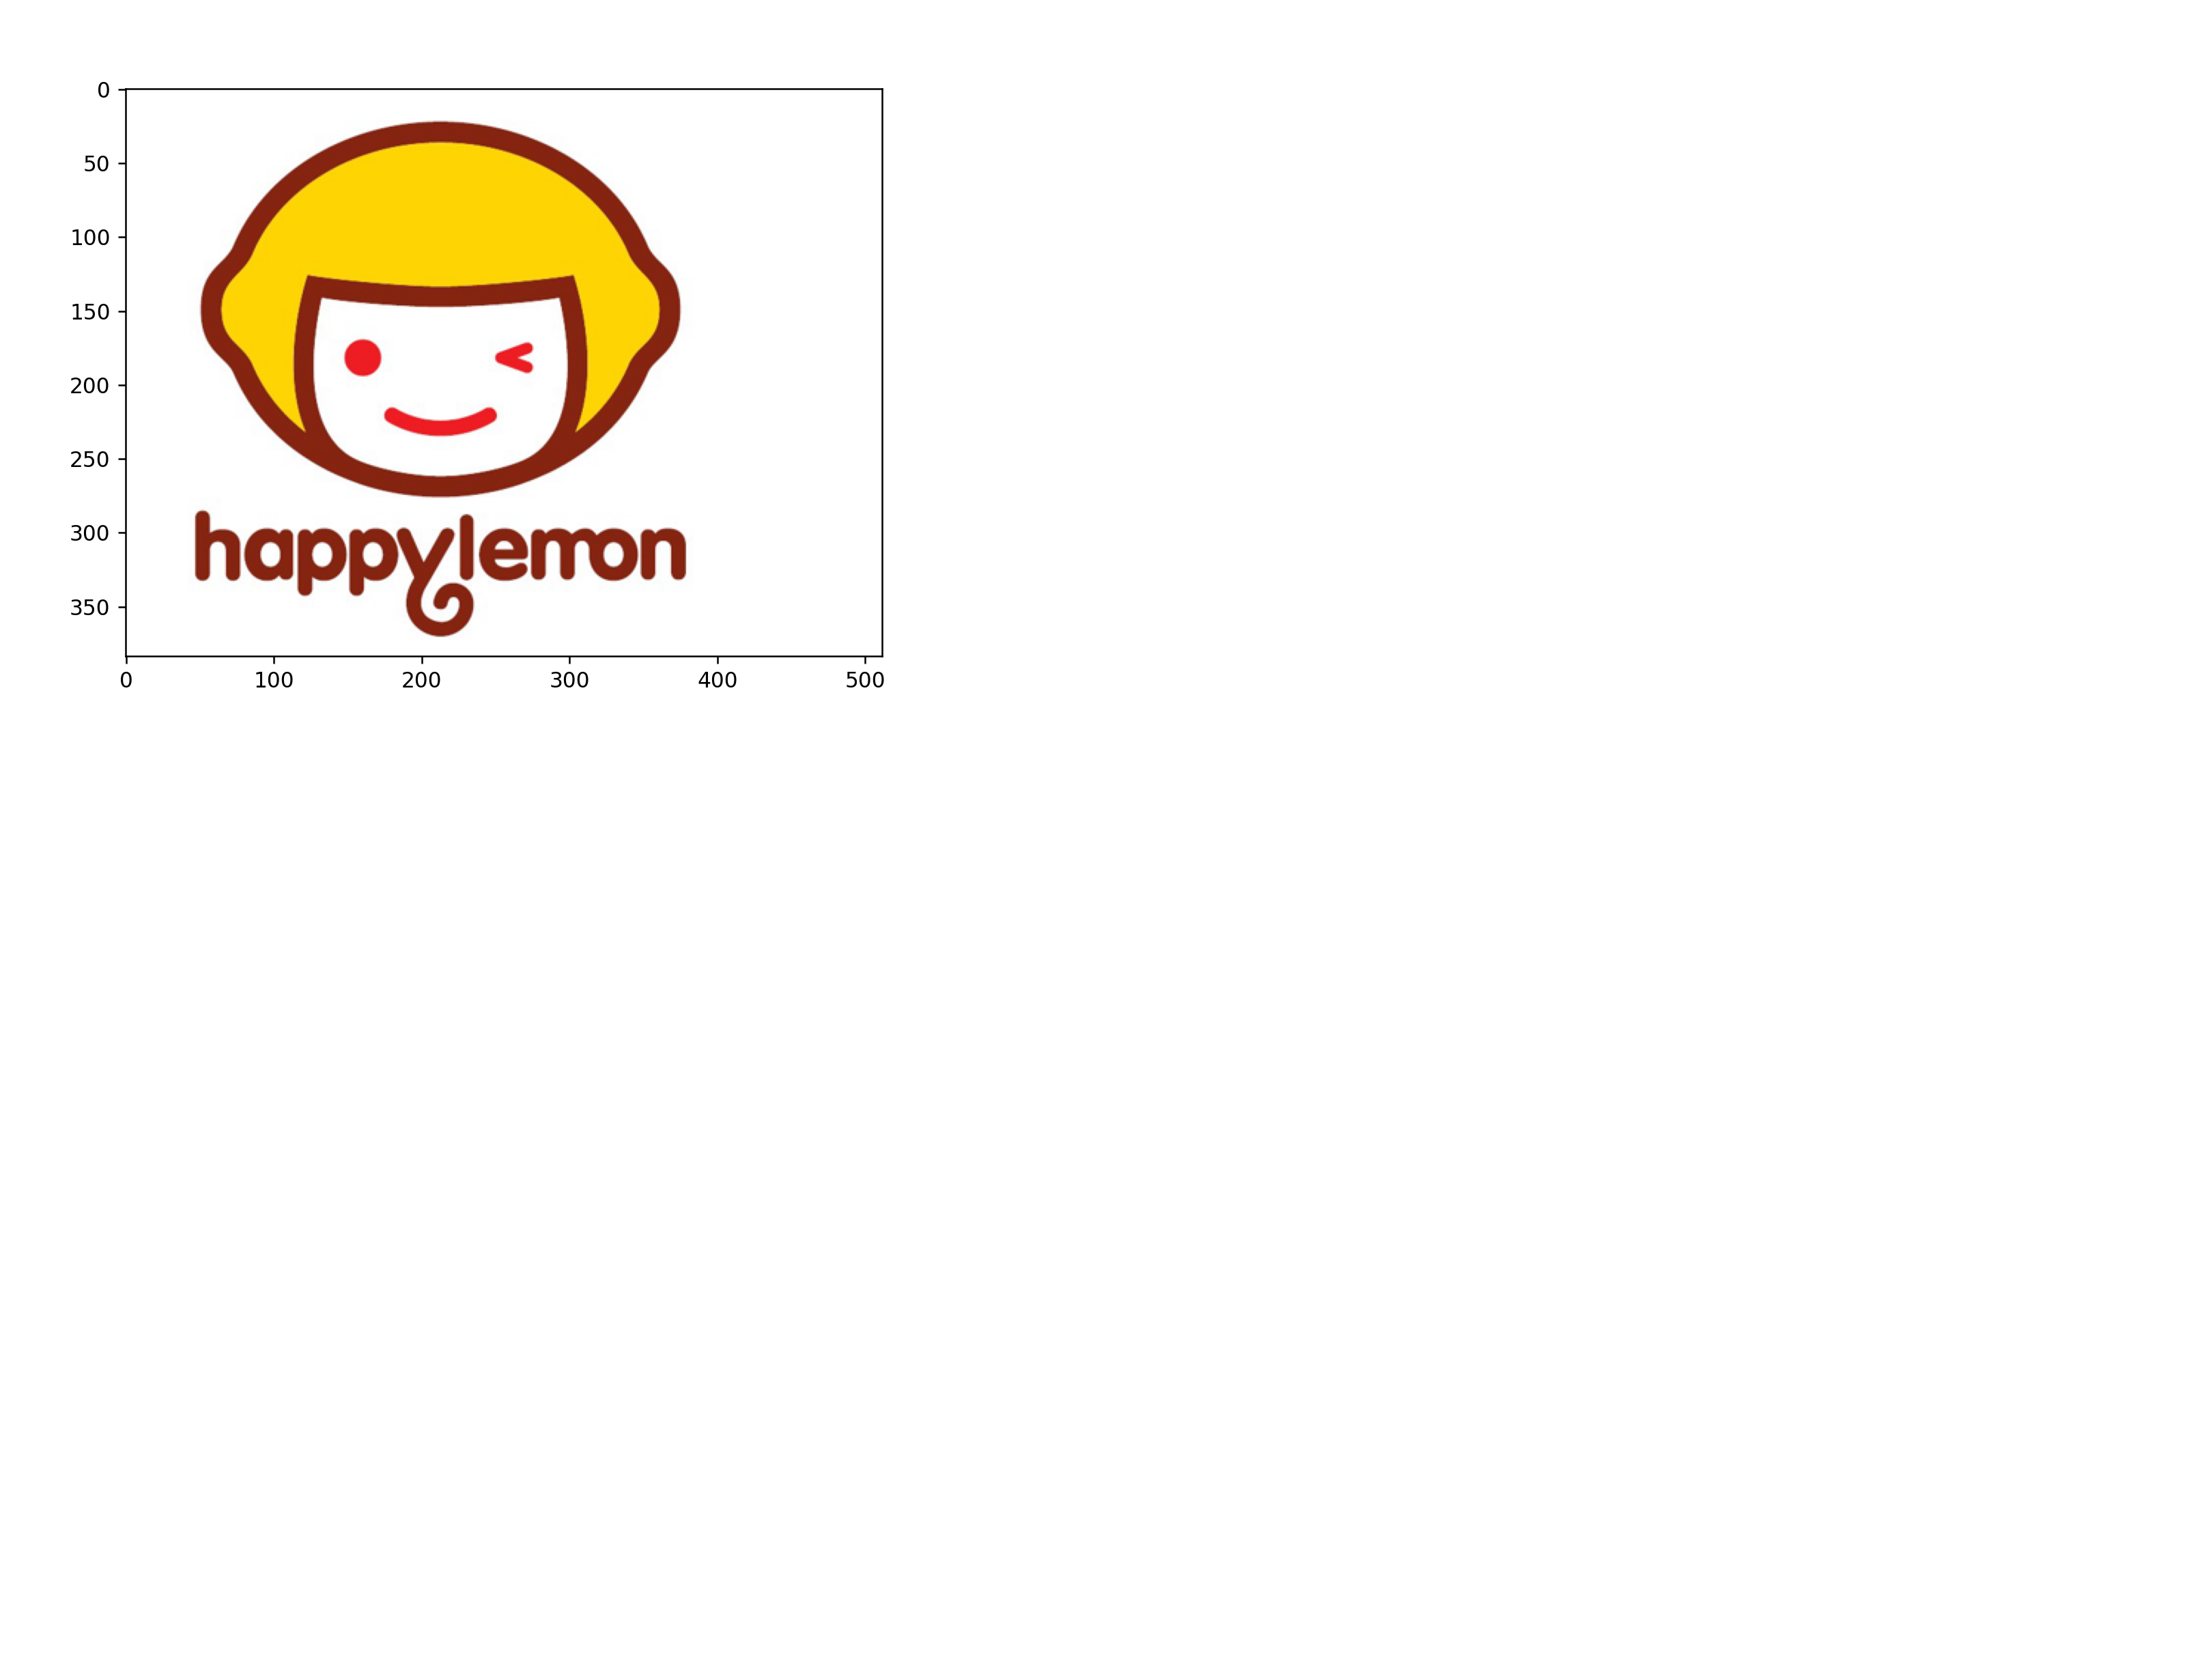

In [12]:
pic = Image.open(r"C:\Users\Hello\Pictures\happylemon.jpg")
resized = expand(pic, (255, 255, 255))
fig, ax = plt.subplots()
ax.imshow(resized)

In [80]:
pic.size

(1024, 768)

In [13]:
def resize(image, dim1, dim2):
    return np.array(Image.fromarray(image).resize(dim1, dim2))

In [155]:
pic, class_ = identify(r"C:\Users\Hello\Desktop\trash93.jpg")

(3, 384, 512)


In [156]:
class_

'other recycling'

<IPython.core.display.Javascript object>


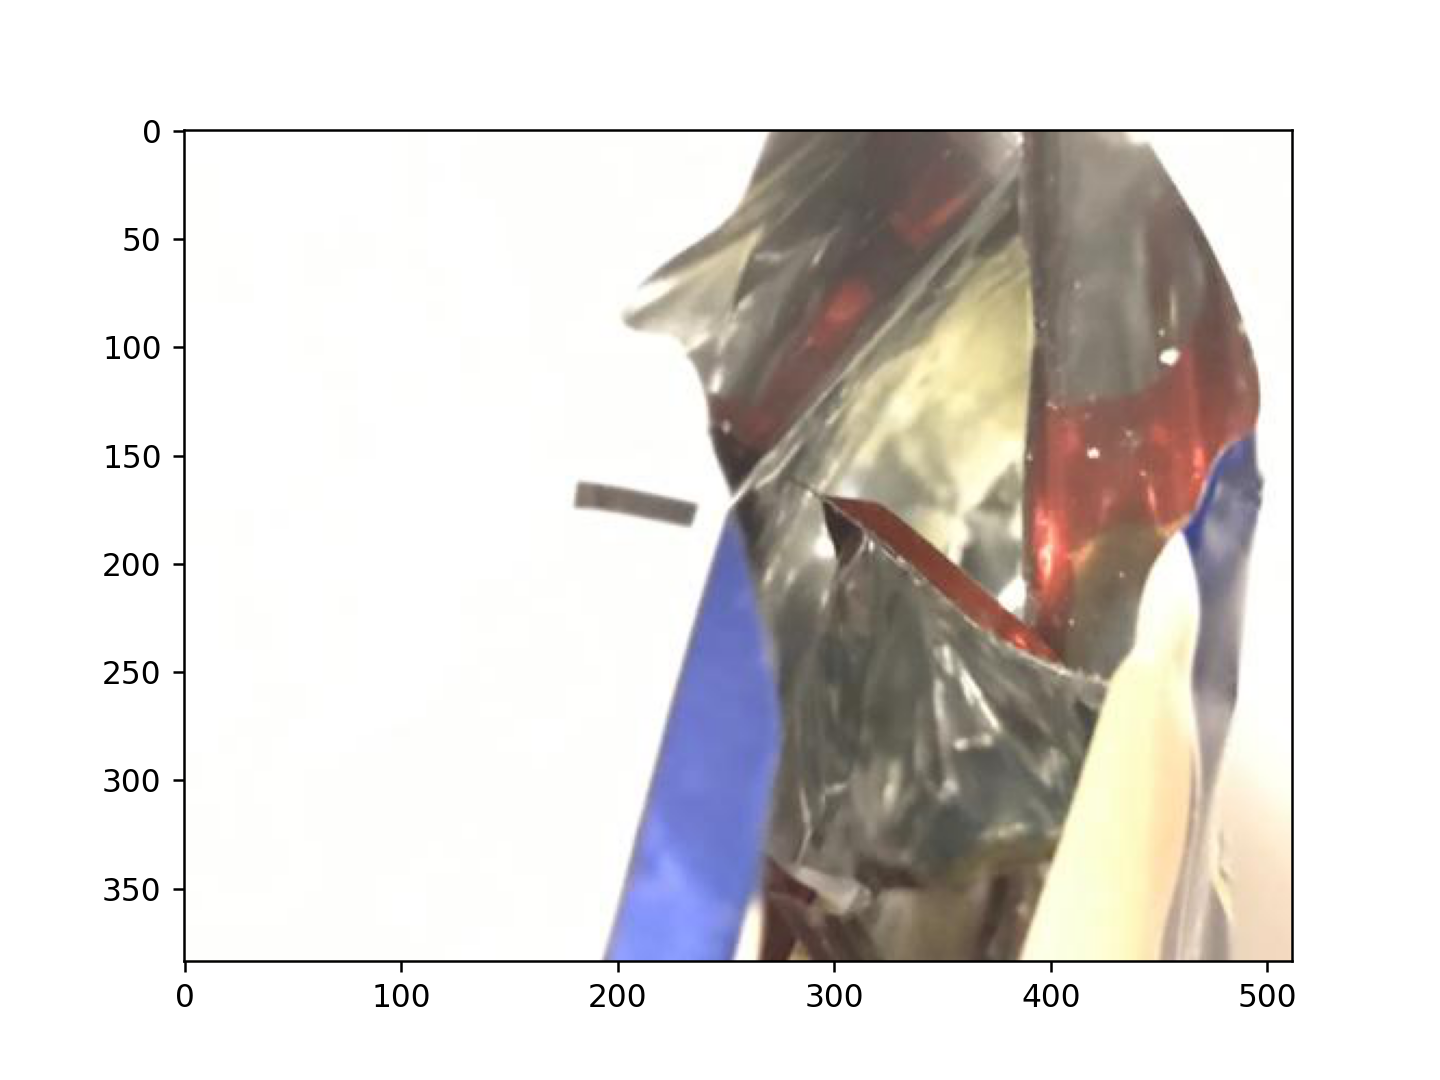

In [157]:
fig, ax = plt.subplots()
ax.imshow(pic)